## Boscacci's Final Project Proposal


__What question/questions are you trying to solve?__
* How well can we guess the final auction price of an (X) on eBay, before we list it?
* How can I help my information security specialist friend classify and visualize incoming requests?


__What are the outcomes you think you will find, and then so what?__

* It is either trivial, challenging, or near-impossible to train an ML model to accurately guess the price of an (X)
* The cyber-security field is either rife with opportunity for data science innovation, or too far out of my domain expertise for me to be helpful


__How would someone, or some entity take action upon learning this?__
* In the event that my eBay model is confidently predictive, one could use it to help arbitrage goods across platforms.
* In the event that my info-sec tool is useful, white-hat pen-testers could use it to visualize apache logs and things.


__What version this question would allow me to find an answer in 2-3 days?__
* How accurate is an eBay predictive model that just goes off of the basic features (with no NLP or CNN action)?
* What if we just visualized incoming web requests / Fail2ban logs?


__What version of this question would allow me/motivate me to work on this problem even after completing Flatiron School?__
* For which eBay product category can I make the most accurate valuator model? Can I put it into practice?
* What other tools can I make for the information security field?


__What are some data sources that would allow you to answer this?__
* eBay API
* My friend in the NAVY


__What is the ideal data you would hope to gather to answer this question?__
* Tens of thousands of previous eBay auctions
* Tens of thousands of server logs and things


__What about potentially missing data, that could cause omitted variable bias?__
* There might be a lot of this, so I will have to get creative about making my sparse data less sparse
* Server logs will not have this problem mostly.


__How will you present your data? Will it be a jupyter notebook presentation or a Dashboard.__
* Dash was a good time, would use again
* Ideally users can make a new eBay listing, run it through the model to get a price guess
* Server log visualizations would be a geo-viz of some kind like a kepler.gl object of some kind


__How will you use regression and/or classification?__
* eBay value estimator will obviously guess the price of new listings
* Info-Sec project would probably try to classify incoming requests as malicious, safe, or unknown or something


__What are the challenges you foresee with this project?__
* Figuring out good model stacking and ninja feature engineering techniques
* Domain-specific challenges having to do with the eBay API responses
* 5000-request daily limit with eBay API


__What are your next steps moving forward?__
* Making hecka requests to the eBay API and collecting data
* Poking and prodding the data every which way possible
* NLP pipeline for titles, description, condition description text
* Think about how I might use the images to help guess price

In [1]:
import json, os, io, requests, csv, re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.display.max_rows = 999
np.set_printoptions(threshold=np.inf)

from scipy.stats import boxcox
from operator import itemgetter
from datetime import datetime

### Here's a JSON Reader

In [2]:
def read_axe_jsons(axe_num):
    with open('axe_listings/%s' % (axe_num), "r") as read_file:
        listing = json.load(read_file)
    with open('axe_specs/%s' % (axe_num), "r") as read_file:
        specs = json.load(read_file)
    return {'listing': listing, 'specs': specs}

### Here's a Guitar (Axe) Class with *Lots* of Attributes (Features)

Some ducking was required for auctions without certain details.

In [3]:
class Axe:
    def __init__(self, axe_num=None):
        
        # UID
        self.id = axe_num
        self.__body = read_axe_jsons("%s" % (axe_num))
        
        # PRICE - SCALAR DEPENDENT VAR (DV)
        self.price_usd = float(self.__body['listing']['sellingStatus'][0]['convertedCurrentPrice'][0]['__value__'])
        
        # SHIPPING COST - SCALAR INDEPENDENT VARIABLE ("IV")
        self.price_shipping = self.__body['listing']['shippingInfo'][0].get('shippingServiceCost')
        if self.price_shipping:
            self.price_shipping = float(self.__body['listing']['shippingInfo'][0]['shippingServiceCost'][0]['__value__'])
        else: self.price_shipping = float(0)
        
        # TITLE - UNSTRUCTURED TEXT DATA FOR NLP ANALYSIS - STUFF WILL BE APPENDED TO THIS LATER
        self.title = self.__body['listing']['title'][0]
        
        # MARKET COUNTRY (ONE-HOT CATEGORICAL VARIABLE)
        self.market = self.__body['listing']['globalId'][0]
        
        # PIC URL (JUST FOR FUNSIES)
        if self.__body['listing'].get('galleryURL'):
            self.pic = self.__body['listing']['galleryURL'][0]
        else: self.pic = None
        
        # BIG PIC URL (JUST FOR FUNSIES)
        if self.__body['listing'].get("pictureURLLarge"):
            self.pic_big = self.__body['listing']['pictureURLLarge'][0]
        else:
            self.pic_big = None
        
        # ITEM URL (JUST FOR FUNSIES)
        self.url = self.__body['listing']['viewItemURL'][0]
        
        # AUTOPAY (ONE-HOT CATEGORICAL VARIABLE)
        self.autopay = self.__body['listing']['autoPay'][0] == 'true'
        
        # SELLER COUNTRY (ONE-HOT CATEGORICAL VAR)
        self.country_seller = self.__body['listing']['country'][0]
        if self.country_seller not in ['US', 'JP', 'CA', 'GB']:
            self.country_seller = 'OTHER'
            
        # RETURNS OFFERED (ONE-HOT)
        self.returns = self.__body['listing']['returnsAccepted'][0] == 'true'
        
        # LISTING INFO (FOR FURTHER PARSING BELOW)
        self.listing_info = self.__body['listing']['listingInfo'][0]
        
        # LISTING TYPE - 1-HOT
        self.listing_type = self.listing_info['listingType'][0]
        
        ################# SHIPPING STUFF #################
        
        # SHIPPING TYPE - 1-HOT CATEGORICAL
        self.ship_type = self.__body['listing']['shippingInfo'][0]['shippingType'][0]
        
        # SHIPPING EXPEDITE - 1-HOT
        self.ship_expedite = self.__body['listing']['shippingInfo'][0]['expeditedShipping'][0] == 'true'
        
        # SHIPPING HANDLING TIME - 1-HOT
        if self.__body['listing']['shippingInfo'][0].get('handlingTime'):
            self.ship_handling_time = int(self.__body['listing']['shippingInfo'][0]['handlingTime'][0])
        else: 
            self.ship_handling_time = 0
        
        # SELLER ZIP CODE (JUST FOR FUNSIES)
        self.zip = self.__body['listing'].get('postalCode')
        
        ################# TEMPORAL STUFF #################
        
        # START AND END TIMES - 1-HOT THE HOUR OF DAY
        self.start_time = datetime.strptime(self.listing_info['startTime'][0], 
                                            "%Y-%m-%dT%H:%M:%S.%fZ")
        self.end_time = datetime.strptime(self.listing_info['endTime'][0], 
                                            "%Y-%m-%dT%H:%M:%S.%fZ")
        
        # START AND END WEEKDAYS - 1-HOT DAY OF WEEK
        self.start_weekday = self.start_time.weekday()
        self.end_weekday = self.end_time.weekday()
        
        # DURATION OF AUCTION IN HOURS - SCALAR NUMBER OF HOURS
        self.__duration = (self.end_time - self.start_time)
        self.duration = round(float(self.__duration.days*24) + float(self.__duration.seconds/60/60), 2)
        
        # RETURN WINDOW DURATION - 1-HOT ENCODE
        if self.returns:
            if self.__body['specs']['ReturnPolicy'].get('ReturnsWithin'):
                self.returns_time = int(self.__body['specs']['ReturnPolicy'].get('ReturnsWithin').split()[0])
        else: self.returns_time = 0
        
        ################# ITEM SPECIFICS: #################
        
        # TEXT DESCRIPTION - UNSTRUCTURED - NLP THIS
        if self.__body['specs'].get('Description'):
            self.description = self.__body['specs']['Description']
        else:
            self.description = None
            # ALSO ONE-HOT ENCODE WHETHER DESCRIPTION EXISTS OR NOT
            
        # SUBTITLE - ONE-HOT ENCODE WHETHER THIS EXISTS OR NOT
        self.subtitle = self.__body['specs'].get('Subtitle')
        # ALSO APPEND IT TO THE ITEM TITLE FOR NLP
        
        # CONDITION DESCRIPTION - ONE-HOT ENCODE WHETHER THIS EXISTS OR NOT
        self.condition_description = self.__body['specs'].get('ConditionDescription')
        # ALSO APPEND TO ITEM TITLE FOR NLP
        
        # NUMBER OF PICS - BIN THESE INTO LESS THAN / GREATER THAN CATEGORIES
        self.pic_quantity = len(self.__body['specs']['PictureURL'])

        # SELLER FEEDBACK SCORE - BIN THIS INTO CATEGORIES
        if self.__body['specs']['Seller'].get('FeedbackScore'):
            self.seller_feedback_score = float(self.__body['specs']['Seller']['FeedbackScore'])
        else: 
            self.seller_feedback_score = None
        
        # SELLER POSITIVE PERCENT - BIN THIS INTO CATEGORIES
        self.seller_positive_percent = float(self.__body['specs']['Seller']['PositiveFeedbackPercent'])
        
        # BEST OFFER ENABLED - ONE-HOT ENCODE
        self.best_offer_enabled = self.__body['specs']['BestOfferEnabled']
        
        ################# NITTY GRITTIES #################
        
        # GET THE ITEM SPECIFICS FOR FURTHER PARSING
        if self.__body['specs'].get('ItemSpecifics'):
            self.__attrs = {prop['Name']:prop['Value'][0] 
                            for prop in self.__body['specs']['ItemSpecifics']['NameValueList']}
            
            # BRAND / MAKE OF GUITAR - 1-HOT ENCODE
            # 1-HOT ENCODE THE MERE EXISTENCE OF THIS VALUE
            self.brand = self.__attrs.get('Brand')
            if self.brand:
                self.brand = self.brand.upper()
                if "GIBSON" in self.brand:
                    self.brand = "GIBSON"
                if "FENDER" in self.brand:
                    self.brand = "FENDER"
                if "SCHECTER" in self.brand:
                    self.brand = "SCHECTER"
                if "MUSIC MAN" in self.brand or "MUSICMAN" in self.brand:
                    self.brand = "MUSIC MAN"
                if "ESP" in self.brand:
                    self.brand = "ESP"
                if "YAMAHA" in self.brand:
                    self.brand = "YAMAHA"
                if "RICKENBACKER" in self.brand:
                    self.brand = "RICKENBACKER"
                if "WASHBURN" in self.brand:
                    self.brand = "WASHBURN"
                if "PRS" in self.brand:
                    self.brand = "PRS"
                if "PAUL REED SMITH" in self.brand:
                    self.brand = "PRS"
                if "GRETSCH" in self.brand:
                    self.brand = "GRETSCH"
                if self.brand not in ['FENDER', 'GIBSON', 'EPIPHONE', 'IBANEZ', 'PRS', 'ESP', 'SCHECTER',
       'JACKSON', 'SQUIER', 'GRETSCH', 'PEAVEY', 'B.C. RICH', 'CHARVEL',
       'DEAN', 'YAMAHA', 'G&L', 'WASHBURN', 'RICKENBACKER']:
                    self.brand = 'OTHER'
            else: self.brand = None
                    
            # MODEL OF GUITAR - DUMP INTO TEXT DESCRIPTION FOR NLP
            # ALSO 1-HOT ENCODE THE EXISTENCE OF THIS VARIABLE
            self.model = self.__attrs.get('Model')
            if self.model:
                self.model = self.model.upper()
                if "LES PAUL" in self.model:
                    self.model = "LES PAUL"
                if "TELECASTER" in self.model:
                    self.model = "TELECASTER"
                if "STRATOCASTER" in self.model:
                    self.model = "STRATOCASTER"
                if "STRAT" in self.model:
                    self.model = "STRATOCASTER"
                if "TELE" in self.model:
                    self.model = "TELECASTER"
                if "SG" in self.model:
                    self.model = "SG"
                if "FLYING V" in self.model:
                    self.model = "FLYING V"
                if "SQUIER" in self.model:
                    self.model = "SQUIER"
                if "EXPLORER" in self.model:
                    self.model = "EXPLORER"
                if "335" in self.model:
                    self.model = "335"
                if "339" in self.model:
                    self.model = "339"
                if "MUSTANG" in self.model:
                    self.model = "MUSTANG"
                if "JAGUAR" in self.model:
                    self.model = "JAGUAR"
#                 if self.model not in ['LES PAUL', 'STRATOCASTER', 'TELECASTER', 'SG', 'CUSTOM', 'VINTAGE',
#        '335', 'FLYING V', 'EXPLORER', 'CLASSIC', '339', 'JAGUAR', 'MUSTANG',
#        'PLUS', 'SINGLECUT', 'EC-1000', 'LEGACY', 'MELODY MAKER',
#        'ASAT CLASSIC', 'G-400', 'WOLFGANG USA', 'CUSTOM 24', 'CUSTOM 22',
#        'SE CUSTOM 24', 'STANDARD', 'CE 24', 'WOLFGANG SPECIAL', 'ES-175', '24',
#        'SQUIER']:
#                     self.model = "OTHER"
            
    
            # YEAR OF MANUFACTURE - IMPORTANT BINNABLE SCALAR WITH MANY MISSING VALUES 
            # 1-HOT ENCODE THE EXISTENCE OF THIS VAR
            if self.__attrs.get('Model Year'):
                self.year = self.__attrs.get('Model Year')[:4]
                if self.year:
                    try:
                        self.year = int(self.year)
                        if self.year == 86:
                            self.year = 1986
                        if self.year < 1700:
                            self.year = None
                    except ValueError:
                        self.year = None      
            else: 
                self.year = None
                
                
            # MATERIAL OF GUITAR BODY - 
            # 1-HOT INCLUSION OF THIS VARIABLE
            # TOSS IT INTO THE NLP STEW
            self.material = self.__attrs.get('Body Material')
            if self.material:
                self.material = self.material.upper()
                if "MAHOGANY" in self.material:
                    self.material = "MAHOGANY"
                if "ROSEWOOD" in self.material:
                    self.material = "ROSEWOOD"
                if "ALDER" in self.material:
                    self.material = "ALDER"
                if "ASH" in self.material:
                    self.material = "ASH"
                if "MAPLE" in self.material:
                    self.material = "MAPLE"
                    
            # HANDEDNESS OF GUITAR (R/L) - 1-HOT THIS
            self.right_left_handed = self.__attrs.get('Right-/ Left-Handed')
            if self.right_left_handed:
                if "R" in self.right_left_handed.upper():
                    self.right_left_handed = "RIGHT"
                else:
                    self.right_left_handed = "LEFT"
            
            
            # COUNTRY OF MANUFACTURE - 1-HOT THIS
            self.country_manufacture = self.__attrs.get('Country/Region of Manufacture')
            if self.country_manufacture:
                self.country_manufacture = self.country_manufacture.upper()
                if self.country_manufacture == 'KOREA, REPUBLIC OF':
                    self.country_manufacture = 'KOREA'
                if self.country_manufacture == 'UNITED STATES':
                    self.country_manufacture = 'USA'
                if self.country_manufacture not in ['USA', 'JAPAN',\
                                                    'MEXICO', 'KOREA',\
                                                    'CHINA','INDONESIA']:
                    self.country_manufacture = 'OTHER'
            
            
            # BODY TYPE
            self.body_type = self.__attrs.get('Body Type')
            if self.body_type:
                self.body_type = self.body_type.upper()
                if self.body_type == "HOLLOW BODY" or self.body_type == "HOLLOWBODY" or self.body_type == "HOLLOW-BODY":
                    self.body_type = "HOLLOW"
                if self.body_type == "SOLID BODY" or self.body_type == "SOLIDBODY" or self.body_type == "SOLID-BODY":
                    self.body_type = "SOLID"
                if "STRAT" in self.body_type:
                    self.body_type = "STRAT"
                if self.body_type not in ['SOLID', 'SEMI-HOLLOW', 'HOLLOW', 'CLASSICAL']:
                    self.body_type = "OTHER"
            
            # STRING CONFIG
            self.string_config = self.__attrs.get('String Configuration')
            if self.string_config:
                self.string_config = self.string_config.upper()
                self.string_config = self.string_config.split()[0]
                if self.string_config.startswith("6"):
                    self.string_config = "6"
                if self.string_config.startswith("12"):
                    self.string_config = "12"
                if self.string_config == "SIX":
                    self.string_config = "6"
                if self.string_config == "TWELVE":
                    self.string_config = "12"
                try:
                    self.string_config = int(self.string_config)
                except TypeError:
                    self.string_config = None
                
                
            
            # BODY COLOR - DUMP (+ "COLORED" for bigram) INTO NLP WITH DESCRIPTION
            # ONE-HOT ENCODE THE EXISTENCE OF THIS VARIABLE
            self.color = self.__attrs.get('Body Color')
            if self.color:
                self.color = self.color.upper()
                if "CHERRY" in self.color:
                    self.color = "RED"
                if "SUNBURST" in self.color:
                    self.color = "SUNBURST"
                if "BURST" in self.color:
                    self.color = "SUNBURST"
                if "MAHOGANY" in self.color:
                    self.color = "NATURAL"
                if "BLUE" in self.color:
                    self.color = "BLUE"
                if "TURQUOISE" in self.color:
                    self.color = "BLUE"
                if "TEAL" in self.color:
                    self.color = "BLUE"
                if "RED" in self.color:
                    self.color = "RED"
                if "BLACK" in self.color:
                    self.color = "BLACK"
                if "EBONY" in self.color:
                    self.color = "BLACK"
                if "WHITE" in self.color:
                    self.color = "WHITE"
                if "GREEN" in self.color:
                    self.color = "GREEN"
                if "NATURAL" in self.color:
                    self.color = "NATURAL"
                if "BLONDE" in self.color:
                    self.color = "NATURAL"
                if "BLOND" in self.color:
                    self.color = "NATURAL"
                if "BEIGE" in self.color:
                    self.color = "NATURAL"
                if "MAPLE" in self.color:
                    self.color = "NATURAL"
                if "BUTTERSCOTCH" in self.color:
                    self.color = "NATURAL"
                if "WALNUT" in self.color:
                    self.color = "NATURAL"
                if "TOBACCO" in self.color:
                    self.color = "NATURAL"
                if "BROWN" in self.color:
                    self.color = "NATURAL"
                if "CREAM" in self.color:
                    self.color = "WHITE"
                if "GOLD" in self.color:
                    self.color = "YELLOW"
                if "YELLOW" in self.color:
                    self.color = "YELLOW"
                if "FIREGLO" in self.color:
                    self.color = "RED"
                if "WINE" in self.color:
                    self.color = "RED"
                if "BURGANDY" in self.color:
                    self.color = "RED"
                if "BURGUNDY" in self.color:
                    self.color = "RED"
                if "MULTI-COLOR" in self.color:
                    self.color = "MULTICOLOR"
                if "AMBER" in self.color:
                    self.color = "YELLOW"
                if "WOOD" in self.color:
                    self.color = "NATURAL"
                if "COPPER" in self.color:
                    self.color = "RED"
                if "PEWTER" in self.color:
                    self.color = "GRAY"
                if "GRAY" in self.color:
                    self.color = "GRAY"
                if self.color not in ['BLACK', 'RED', 'SUNBURST', 'WHITE', 'NATURAL', 'BLUE', 'YELLOW',
                                       'GREEN']:
                    self.color = "OTHER"
            else: self.color = None
        
        # INITIALIZING VARIABLES THAT DIDN'T GET ASSIGNED VALUES
        else:
            self.color = self.brand = self.model = None
            self.material = self.right_left_handed = self.country_manufacture = None
            self.body_type = self.string_config = self.listing_type = None    
            self.year = None
        
        # ATTEMPT TO SCRAPE YEAR FROM TEXT FIELDS
        year_pat = re.compile(r'(?<!NO )(?<!IN )(?<!MODEL )(?<!SINCE )(?<![\dA-Za-z-])(20[01]\d)(?!\d|\'|s)|(?<!NO )(?<!IN )(?<!MODEL )(?<!SINCE )(19[23456789]\d)(?!\d|\'|s)')
        
        if self.year == None or self.year == None:
            if re.findall(year_pat, self.title):
                self.year = re.findall(year_pat, self.title)[-1]
            elif self.subtitle and re.findall(year_pat, self.subtitle):
                self.year = re.findall(year_pat, self.subtitle)[-1]
            elif self.condition_description and re.findall(year_pat, self.condition_description):
                self.year = re.findall(year_pat, self.condition_description)[-1]
            elif self.description and re.findall(year_pat, self.description):
                self.year = re.findall(year_pat, self.description)[-1]
        if type(self.year) == tuple:
            try:
                self.year = int(self.year[0])
            except TypeError:
                self.year = int(self.year[1])

### Loop Through All Guitar JSON Data Files, Instantiate AXE Class Objects

In [4]:
filenames = [name for name in os.listdir('axe_specs/') if not name.startswith('.')] # Ignores hidden files on mac

In [5]:
axes = []
for filename in filenames:
    try:
        this_axe = Axe(filename)
        if "LOT OF" not in this_axe.title.upper() and this_axe.price_usd > 100 and this_axe.price_usd < 5000:
            if this_axe.string_config and this_axe.string_config < 5:
                continue
            axes.append(this_axe)
    except ValueError:
        pass

In [6]:
axes = [axe for axe in axes]

In [7]:
len(axes) # Our sample size.

12987

********

## EDA

**********

__Price Distribution:__

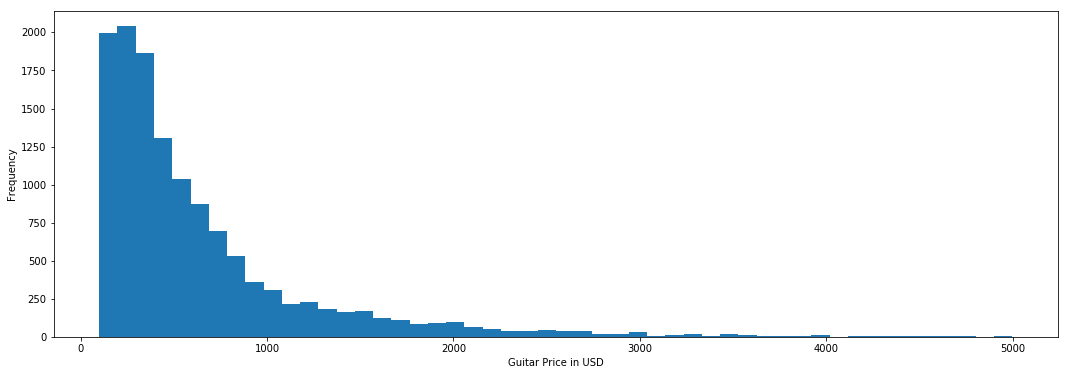

In [8]:
prices = pd.Series([axe.price_usd for axe in axes])
plt.figure(figsize = (18,6))
plt.hist(prices, bins=50)
plt.ylabel('Frequency')
plt.xlabel('Guitar Price in USD')
plt.show()

Some of the most expensive guitars:

In [9]:
spensive = [{'name':axe.title,
             'price': axe.price_usd,
            'year':axe.year} for axe in axes]
sorted(spensive, key=itemgetter('price'))[-5:]

[{'name': "D'ANGELICO ARCHTOP MADE IN U.S.A HANDMADE GUITAR MODEL NEW YORKER II W/CASE",
  'price': 4990.0,
  'year': 1992},
 {'name': 'Parker Fly Supreme Guitar Trans Honey - hand-made at original factory - pristine',
  'price': 4990.0,
  'year': None},
 {'name': '10th Anniversary Ibanez Jem - Great Condition - Very Hard to Find guitar',
  'price': 4995.0,
  'year': 1996},
 {'name': 'Original USA-Built Steinberger GL2T TransTrem Guitar - Restored by Jeff Babicz! ',
  'price': 4995.0,
  'year': None},
 {'name': 'PRS PRIVATE STOCK SINGLECUT', 'price': 4999.0, 'year': None}]

**********

__Text Fields, for NLP:__

Listing Title:

In [10]:
[axe.title for axe in axes][:10] # All listings must have a title

['Fender Telecaster Vintage Electric Guitar MIM, 1994, Crimson Red',
 '2015 Gibson Les Paul LPM',
 'Ibanez Gio GRGBD120XL Left Handed Electric Guitar in Black Locking Tremelo',
 'Fender EVH Wolfgang Special Stealth WITH HARDSHELL CASE',
 "1960's Teisco Del Rey ET-200  MIJ Made in Japan Electric Guitar Sunburst ",
 'Jackson  Dinky JS  Gun Metal Gray',
 'Ibanez RG420EG SBK (Spiderweb Black) Guitar. Free Gig Bag & Free Shipping.',
 "HURRICANE BY MORRIS TELE MADE IN JAPAN IN 90'S TELE-GIB TYPE MOD EX. CONDITION",
 'Laguna LE50 Short-Scale Electric Guitar Satin Black',
 '2006 fender stratocaster 60th edition MIM  MZ6145842']

Mean Length of Title:

In [11]:
mean_title_len = sum(len(axe.title) for axe in axes)/len(axes)
print(f'{round(mean_title_len)} characters per title on average.')

58 characters per title on average.


In [12]:
print(f'{round(sum(1 for axe in axes if len(axe.title) < 46) / len(axes)*100,2)}% of listings have less than 46 characters in the title.')

25.76% of listings have less than 46 characters in the title.


Maybe "title has length less than 46 characters" should be a one-hot variable.

### Check for  "For parts" "as-is" etc

Listing __Sub__titles:

In [13]:
[axe.subtitle for axe in axes if axe.subtitle != None][-5:]

['offers considered',
 'offers considered',
 'offers considered',
 'Great Value! Open box discount & free 2-year warranty!',
 'Great Value! Open box discount & free 2-year warranty!']

In [14]:
print(f'{round(((len([axe.subtitle for axe in axes if axe.subtitle != None]) / len(axes))*100),2)}% of listings include a subtitle.')

2.75% of listings include a subtitle.


Condition Descriptions:

In [15]:
[axe.condition_description for axe in axes if axe.condition_description != None][-5:]

["Good Condition. This guitar shows a lot of wear on its neck, and there is a small finish blemish on the bottom of the body's bass side. Tested to factory spec. Please see the photos above; they are of the actual item for sale.",
 'Item history unknown; Works; has cracked head; cosmetic damage to body',
 'Plays and sounds awesome!! Good Condition!! Shows some signs of light wear with a few light dings and very light scratches. Please see photos.',
 'Guitar in excellent condition. Please see the photos above; they are of the actual item for sale.',
 'Plays and sounds awesome!  Shows some signs of aging and wear with a few light dings and light scratches.  Case is rough but functional.  Please see all the photos.']

In [16]:
print(f'{round(((len([axe.condition_description for axe in axes if axe.condition_description != None]) / len(axes))*100),2)}% of listings include a condition description.')

32.61% of listings include a condition description.


Example of Description Full Text:

In [17]:
[axe.description for axe in axes][2000]

"Gibson LPJ 6 String LEFT HANDED Electric Guitar Natural Cherry Finish + Gig Bag THIS IS A LEFT HANDED GUITAR! All of the pictures in the gallery above, are of the actual guitar that you will receive. I also have over 50 pictures in the album that is linked below. The guitar has been played and well cared for. Well cared for doesn't mean that it is perfect, some small cosmetic blemishes are present. There are some small dings along the edges of the body. Back has a larger scratch near the black cover plate. Overall the guitar is in very good condition. The neck is securely in place and straight. No signs of repair or alterations to the neck. Also includes a Gibson padded Gig bag. The serial number is: 133421301LPJ 2013 Model Strings will be loosened prior to shipping, in order to relieve pressure from the neck. Click Here To See Many More PicturesSEE PICTURES Shipping: Shipping to a confirmed address in the 48 states will be $35.00 Alaska, Hawaii and all US Territories may incur an add

In [18]:
print(f'{round(((len([axe.description for axe in axes if axe.description != None]) / len(axes))*100),2)}% of listings include a text description.')

99.25% of listings include a text description.


***********

__Number of Pics on eBay listing:__

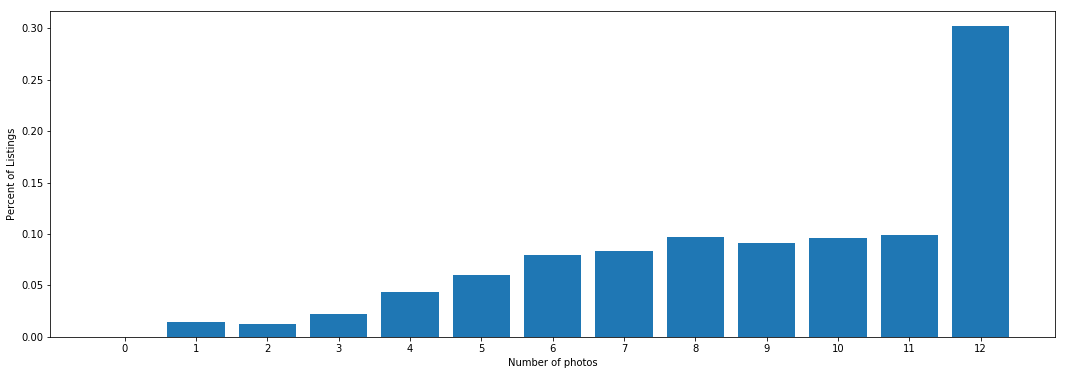

In [19]:
pic_quants = pd.Series([axe.pic_quantity for axe in axes]).value_counts()
plt.figure(figsize = (18,6))
plt.bar(pic_quants.index, pic_quants.values/len(axes))
plt.xticks(pic_quants.index)
plt.xlabel("Number of photos")
plt.ylabel("Percent of Listings")
plt.show()

In [20]:
for num_photos in range(13,0,-1):
    print(f'{round(len([axe.pic_quantity for axe in axes if axe.pic_quantity < num_photos]) / len(axes) * 100, 1)}% of auctions have less than {num_photos} photos.')

100.0% of auctions have less than 13 photos.
69.8% of auctions have less than 12 photos.
59.9% of auctions have less than 11 photos.
50.3% of auctions have less than 10 photos.
41.2% of auctions have less than 9 photos.
31.5% of auctions have less than 8 photos.
23.2% of auctions have less than 7 photos.
15.2% of auctions have less than 6 photos.
9.2% of auctions have less than 5 photos.
4.8% of auctions have less than 4 photos.
2.6% of auctions have less than 3 photos.
1.4% of auctions have less than 2 photos.
0.0% of auctions have less than 1 photos.


__Thumbnail Image URLs__ — for Potential (CNN, maybe) Image Analysis as a factor in price

In [21]:
[axe.pic for axe in axes][:5] # Just first five. You get it

['http://thumbs2.ebaystatic.com/m/mi0yHKrebkFb2j2Q2Hq94nQ/140.jpg',
 'http://thumbs4.ebaystatic.com/m/mFax7qfKyVwHNv_LkUoh8uQ/140.jpg',
 'http://thumbs3.ebaystatic.com/m/maT-GoD60SDnPBWiBilfcSw/140.jpg',
 'http://thumbs1.ebaystatic.com/m/m7xu512GJIRPEDaiIEZswiw/140.jpg',
 'http://thumbs4.ebaystatic.com/m/mGQq5m8H2Po8MbwBz2hOwSg/140.jpg']

**********

**Shipping Type:**

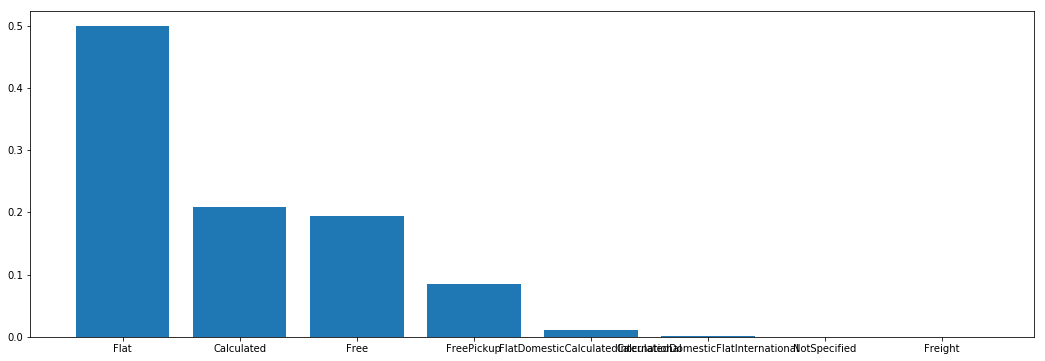

In [22]:
plt.figure(figsize = (18,6))
ship_counts = pd.Series([axe.ship_type for axe in axes]).value_counts()
plt.bar(ship_counts.index, ship_counts.values/len(axes))
plt.show()

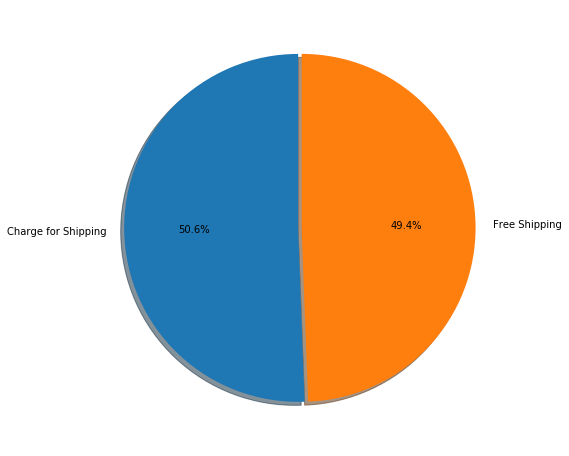

In [23]:
free = pd.Series([axe.price_shipping == 0 for axe in axes]).value_counts()
plt.figure(figsize = (8,8))
plt.pie(free.values, explode=[.01,.01], labels=['Charge for Shipping', 'Free Shipping'], 
        autopct='%1.1f%%',
       shadow = True,
       startangle=90)
plt.show()

In [24]:
print(f'${round(sum(axe.price_shipping for axe in axes if axe.price_shipping != 0) / len([axe.price_shipping for axe in axes if axe.price_shipping]),2)} - Average shipping cost (of those charging for shipping)')

$55.44 - Average shipping cost (of those charging for shipping)


**Offering Expedited Shipping:**

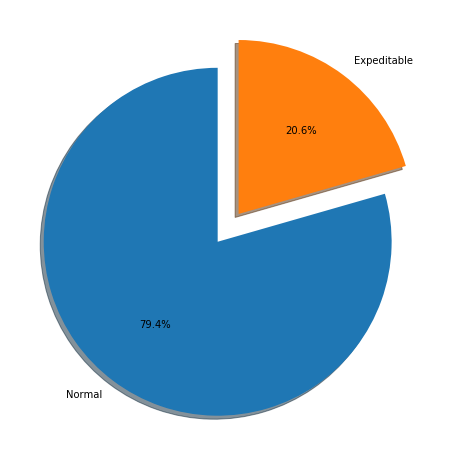

In [25]:
exp = pd.Series([axe.ship_expedite for axe in axes]).value_counts()
plt.figure(figsize = (8,8))
plt.pie(exp.values, explode=[.1,.1], labels=['Normal', 'Expeditable'], 
        autopct='%1.1f%%',
       shadow = True,
       startangle=90)
plt.show()

****

__Listing Types:__

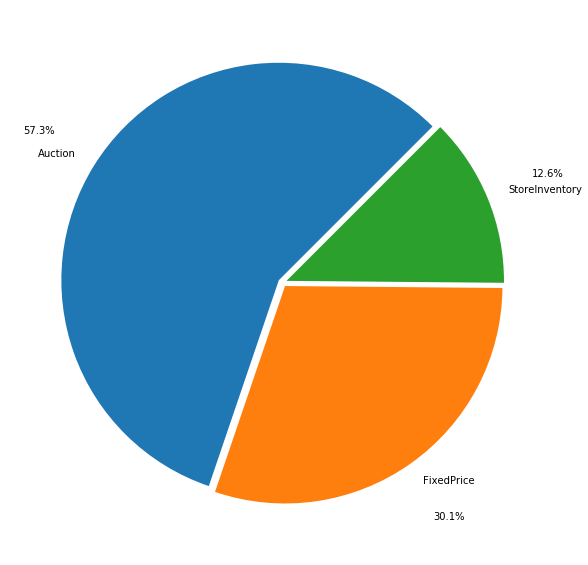

In [26]:
listing_types = pd.Series([axe.listing_type for axe in axes if axe.listing_type != None]).value_counts()
plt.figure(figsize = (10,10))
plt.pie(listing_types.values, 
        labels = listing_types.index,
        autopct='%1.1f%%',
        pctdistance = 1.3,
       startangle=45,
        explode = np.full(len(listing_types), .02))
plt.show()

****

__TEMPORAL STUFF__

**Handling Time in Days:**

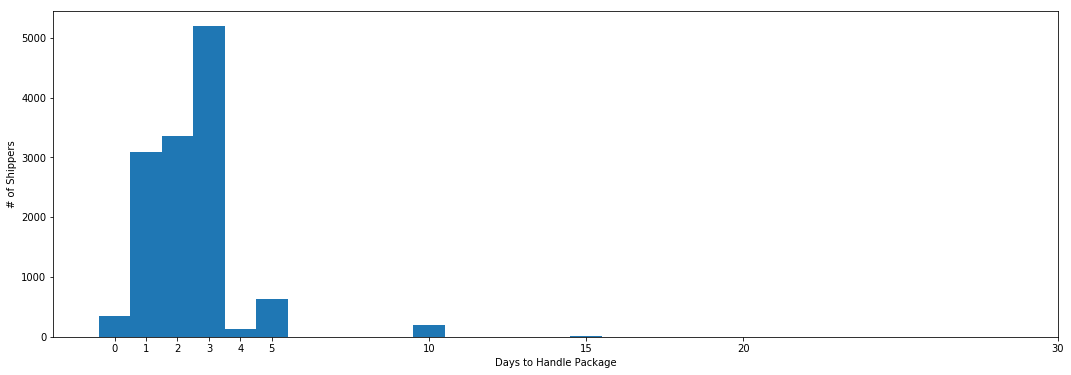

In [27]:
plt.figure(figsize = (18,6))
times = pd.Series([axe.ship_handling_time for axe in axes if axe.ship_handling_time != None])
plt.hist(times, bins=np.arange(max(times))-.5)
plt.xticks(sorted(times.value_counts().index))
plt.xlabel('Days to Handle Package')
plt.ylabel('# of Shippers')
plt.show()

__Duration of Auction in Days__:

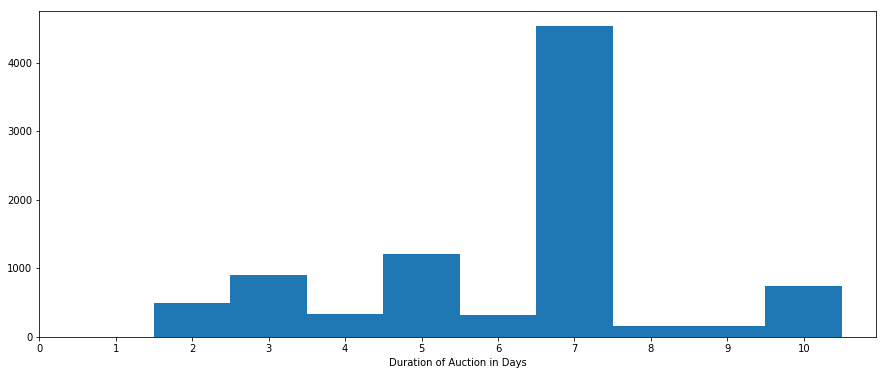

In [28]:
plt.figure(figsize = (15,6))
plt.hist([axe.duration/24 for axe in axes], bins = np.arange(10)+1.5)
plt.xticks(range(11))
plt.xlabel('Duration of Auction in Days')
plt.show()

**Weekday of Auction Start:**

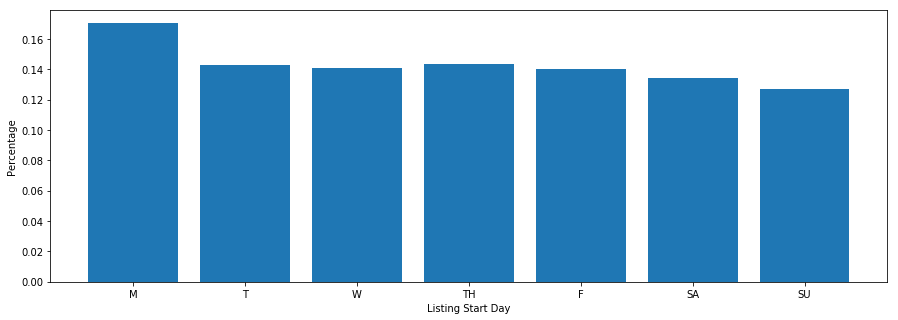

In [29]:
days = pd.Series([axe.start_weekday for axe in axes]).value_counts()
plt.figure(figsize = (15,5))
plt.bar(days.index, days.values/len(axes))
plt.xticks(range(7), 'M T W TH F SA SU'.split(' '))
plt.xlabel("Listing Start Day")
plt.ylabel('Percentage')
plt.show()

**Weekday of Auction End:**

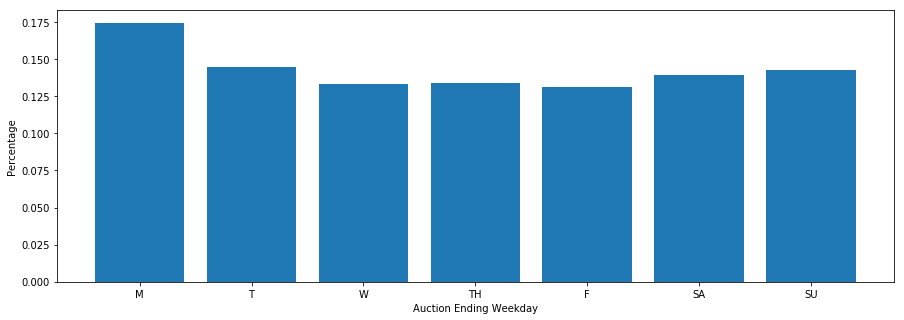

In [30]:
days = pd.Series([axe.end_weekday for axe in axes]).value_counts()
plt.figure(figsize = (15,5))
plt.bar(days.index, days.values/len(axes))
plt.xticks(range(7), 'M T W TH F SA SU'.split(' '))
plt.ylabel('Percentage')
plt.xlabel("Auction Ending Weekday")
plt.show()

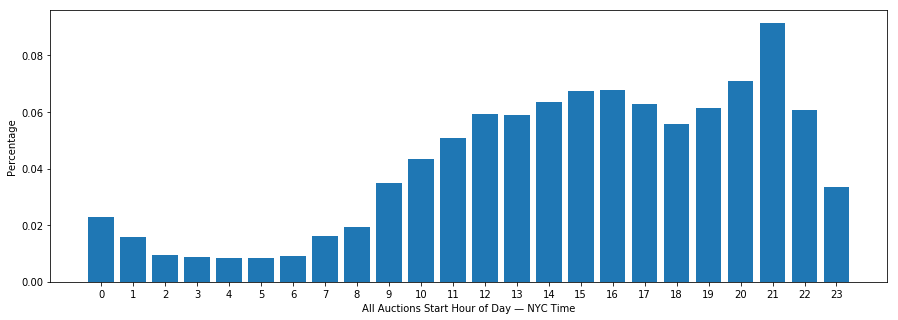

In [31]:
start_hours = pd.Series([axe.start_time.hour for axe in axes]).value_counts()
plt.figure(figsize = (15,5))
plt.bar((start_hours.index-5+24)%24, start_hours.values/len(axes))
plt.xticks(range(0,24))
plt.ylabel('Percentage')
plt.xlabel("All Auctions Start Hour of Day — NYC Time")
plt.show()

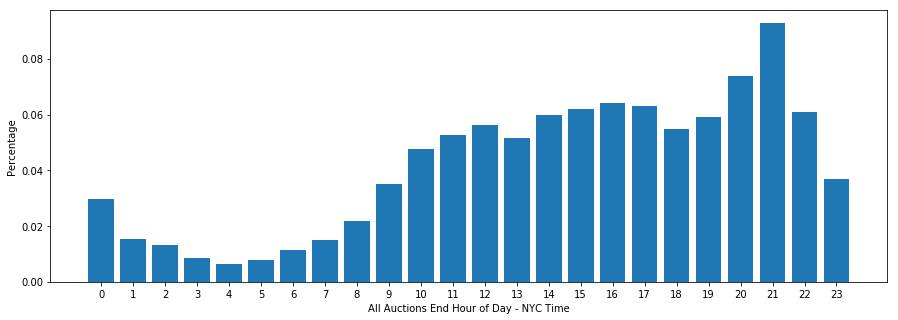

In [32]:
end_hours = pd.Series([axe.end_time.hour for axe in axes]).value_counts()
plt.figure(figsize = (15,5))
plt.bar((end_hours.index - 5 + 24)%24, end_hours.values/len(axes))
plt.xticks(range(0,24))
plt.ylabel('Percentage')
plt.xlabel("All Auctions End Hour of Day - NYC Time")
plt.show()

**Percentage of Auctions Offering Returns:**

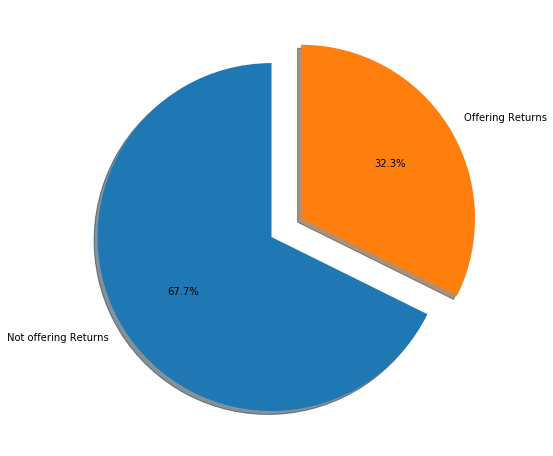

In [33]:
returns = pd.Series([axe.returns for axe in axes]).value_counts()
plt.figure(figsize = (8,8))
plt.pie(returns.values, explode=[.1,.1], labels=['Not offering Returns', 'Offering Returns'], 
        autopct='%1.1f%%',
       shadow = True,
       startangle=90)
plt.show()

**Return Time Window** (of those offering returns):

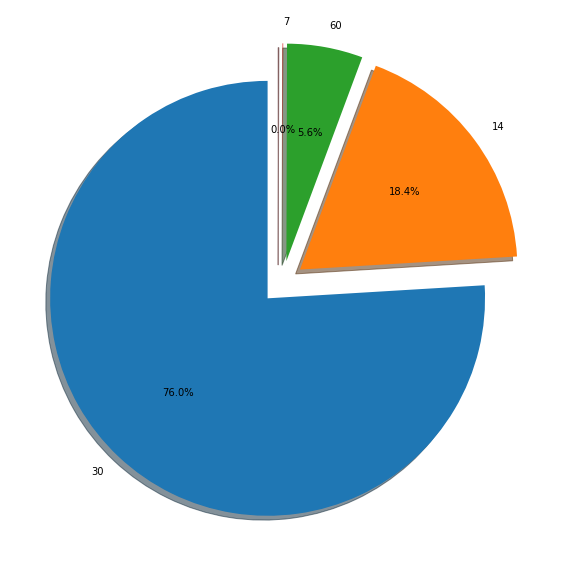

In [34]:
returns = pd.Series([axe.returns_time for axe in axes if axe.returns_time > 0]).value_counts()
plt.figure(figsize = (10,10))
plt.pie(returns.values, explode=np.full(len(returns), .1), labels = returns.index, 
        autopct='%1.1f%%',
       shadow = True,
       startangle=90)
plt.show()

**Offering AutoPay:**

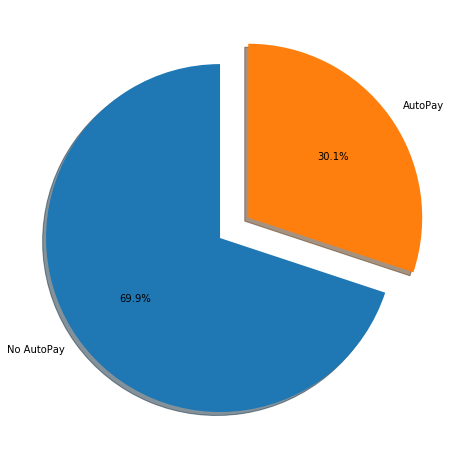

In [35]:
auto = pd.Series([axe.autopay for axe in axes]).value_counts()
plt.figure(figsize = (8,8))
plt.pie(auto.values, explode=[.1,.1], 
        labels=['No AutoPay', 'AutoPay'], 
        autopct='%1.1f%%',
       shadow = True,
       startangle=90)
plt.show()

****

__"Best Offer":__

In [36]:
print(f'{round((sum(axe.best_offer_enabled for axe in axes) / len(axes)*100),2)}% of listings have "Best Offer" enabled.')

39.75% of listings have "Best Offer" enabled.


***

**Countries of Sellers:**

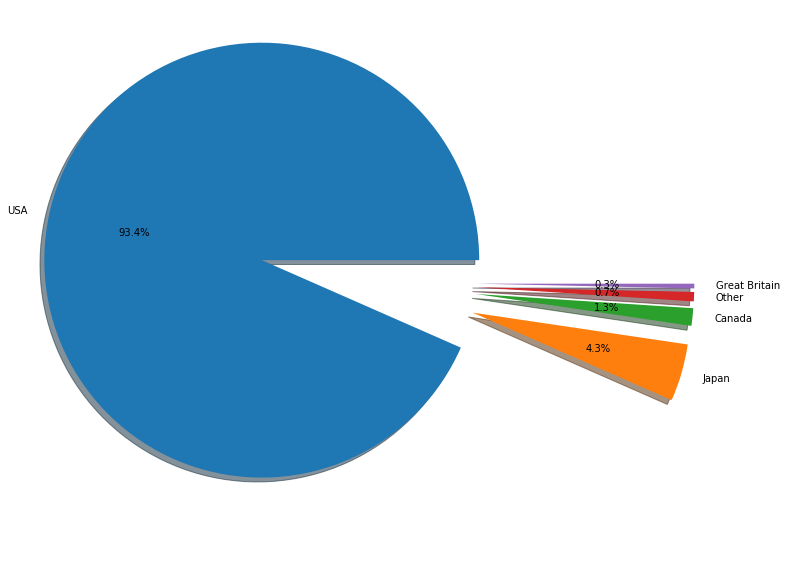

In [37]:
plt.figure(figsize = (10,10))
countries = pd.Series([axe.country_seller for axe in axes]).value_counts()
plt.pie(countries.values, labels=['USA', 'Japan', 'Canada', 
                                  'Other','Great Britain'], 
                            explode = np.full(len(countries), .5), 
        autopct='%1.1f%%',
       shadow = True)
plt.show()

__Seller Karma:__

Ebay Seller Feedback Score:

/anaconda3/envs/air/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/envs/air/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


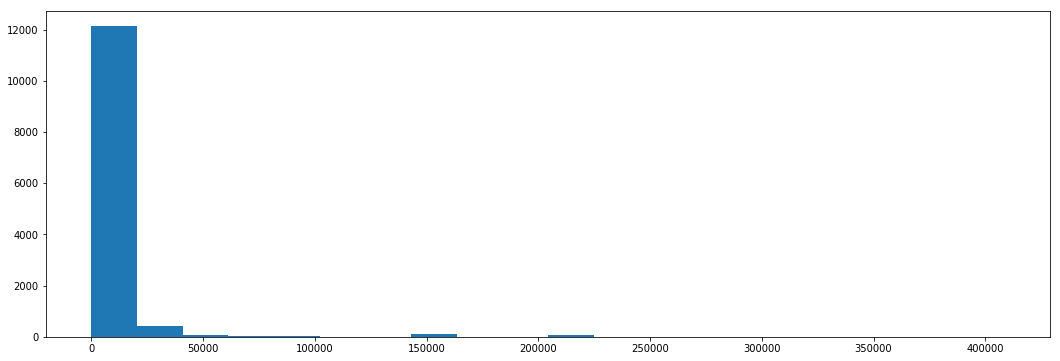

In [38]:
scores = pd.Series([axe.seller_feedback_score for axe in axes])
plt.figure(figsize = (18,6))
plt.hist(scores, bins=20)
plt.show()

In [39]:
scores.min(), scores.max()

(-2.0, 408593.0)

Pretty loooooong tail there. Let's chop it to see a little closer:

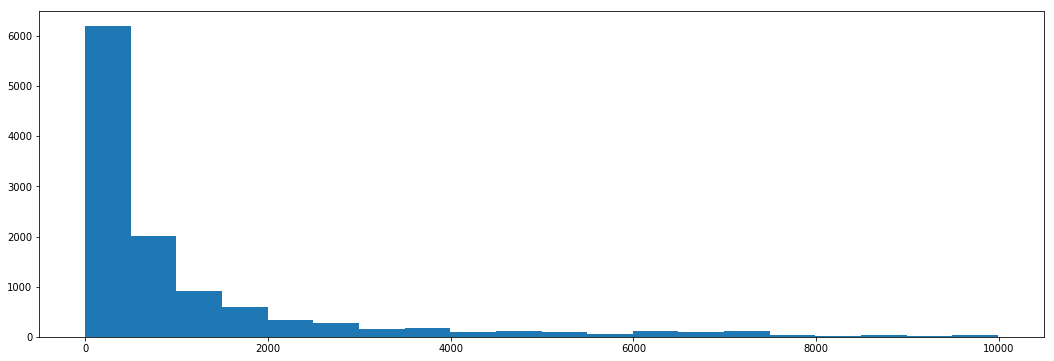

In [40]:
scores = pd.Series([axe.seller_feedback_score for axe in axes if axe.seller_feedback_score != None and axe.seller_feedback_score < 10000])
plt.figure(figsize = (18,6))
plt.hist(scores, bins=20)
plt.show()

eBay Positive Feedback Percentage:

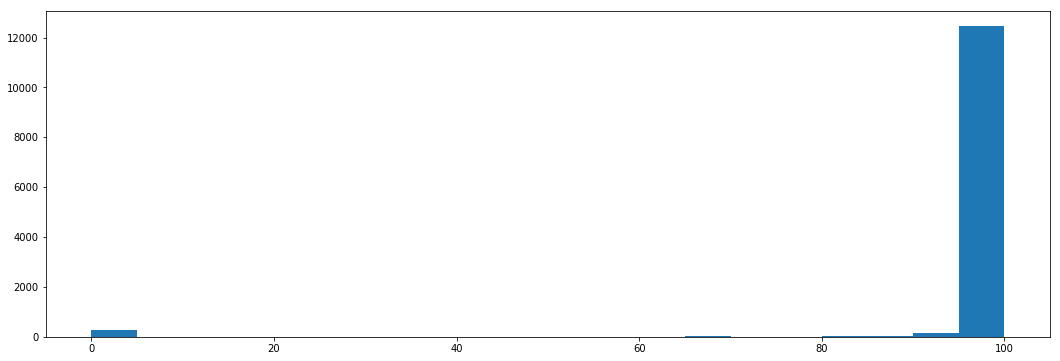

In [41]:
scores = pd.Series([axe.seller_positive_percent for axe in axes])
plt.figure(figsize = (18,6))
plt.hist(scores, bins=20)
plt.show()

***

__Guitars: Countries of Manufacture:__

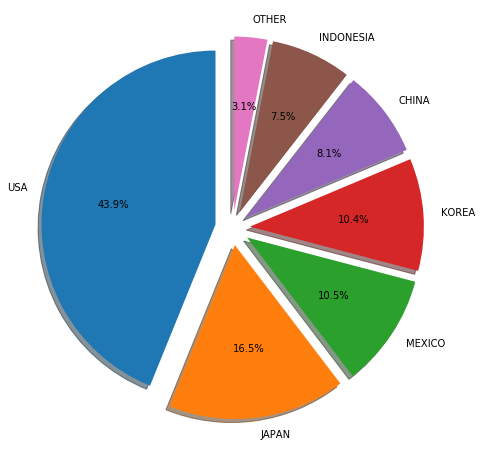

In [42]:
plt.figure(figsize = (8,8))
countries = pd.Series([axe.country_manufacture for axe in axes]).value_counts()
plt.pie(countries.values, labels= countries.index, explode = np.full(len(countries), .1), 
        autopct='%1.1f%%',
       shadow = True,
       startangle=90)
plt.show()

***

__Guitar Body Colors:__

In [43]:
colors = pd.Series([axe.color for axe in axes if axe.color != None]).value_counts()
colores = list(colors.index)
colores[2] = 'ORANGE'
colores[3] = 'PINK'
colores[4] = 'BEIGE'
colores[5] = 'TAN'
# colores

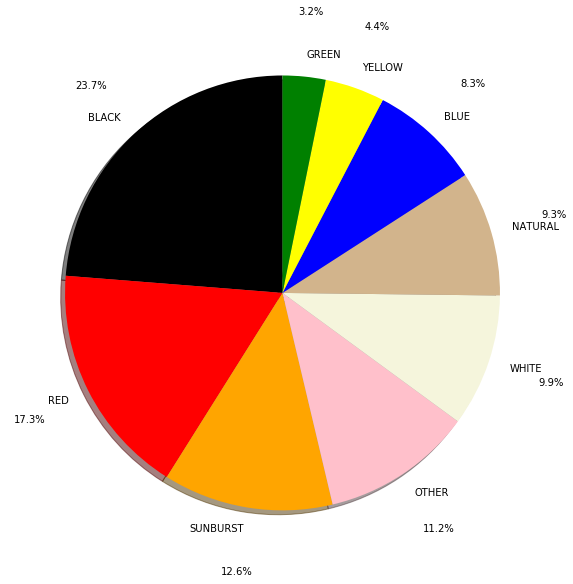

In [44]:
plt.figure(figsize = (10,10))
plt.pie(colors.values, labels=colors.index,
        autopct='%1.1f%%',
        pctdistance = 1.3,
       shadow = True,
       startangle=90,
       colors = colores)
plt.show()

In [45]:
per = round((sum(pd.Series([axe.color for axe in axes if axe.color != None]).value_counts() / len(axes))*100),2)
print(f'{per}% of auctions list a body color where they\'re supposed to.')

56.92% of auctions list a body color where they're supposed to.


***

__Age of Guitars:__

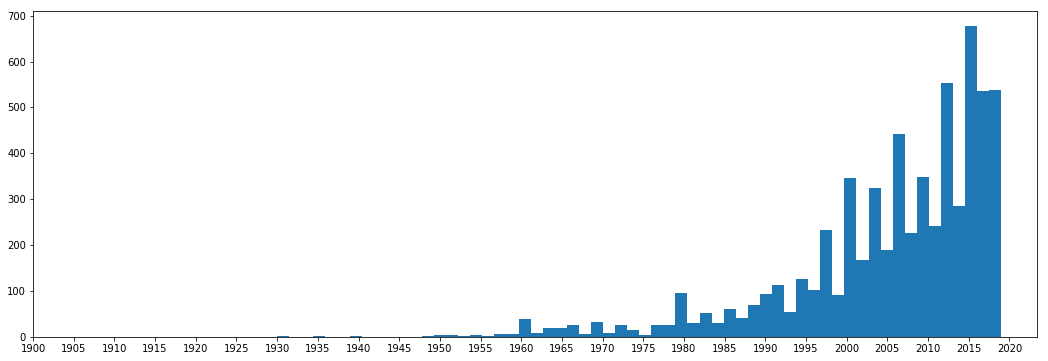

In [46]:
years = pd.Series([axe.year for axe in axes if axe.year != None])
plt.figure(figsize = (18,6))
plt.hist(years, bins=60)
plt.xticks(np.arange(1900,2021,5))
plt.show()

In [47]:
print(f'{round((len(years) / len(axes) * 100),2)}% of auctions have year values...might want to impute or something')

48.91% of auctions have year values...might want to impute or something


### What if we just bin years, drawing the line where it really matters?

***

__US Seller Locations, by Zip Code:__

In [48]:
sales = [(axe.zip[0], axe.start_time) for axe in axes if axe.country_seller == 'US' and axe.zip != None]

In [49]:
def get_usa_zips(url):
    usa_zips = {}
    census_zip_latlon = io.StringIO(requests.get(url).text)
    dialect = csv.Sniffer().sniff(census_zip_latlon.read(1024))
    census_zip_latlon.seek(0)
    reader = csv.reader(census_zip_latlon, dialect)
    for row in reader:
        usa_zips[row[0]] = (row[1], row[2])
    return usa_zips

In [50]:
usa_zips = get_usa_zips(r'https://goo.gl/oYwpRM')

In [51]:
sales = [sale for sale in sales if sale[1] > datetime.strptime('2018-08-01', '%Y-%m-%d')]

In [52]:
def write_kepler_csv():
    with open('for_kepler.csv', mode='w') as sale_lat_long_datetime_file:

        sales_writer = csv.writer(sale_lat_long_datetime_file, delimiter=',', 
                                                           quotechar='"', 
                                                           quoting=csv.QUOTE_MINIMAL)

        ## The sample data set I got from the kepler github repo had rows named like so:
        sales_writer.writerow(['latitude','longitude','tpep_sale_datetime'])
        omissions = 0
        
        for sale in sales:
            try:
                datetime = sale[1]
                lat = usa_zips[sale[0]][0]
                lon = usa_zips[sale[0]][1]
                sales_writer.writerow([lat, lon,datetime])
            except KeyError:
                omissions += 1
        print (f"{round((omissions/len(sales))*100, 2)}% of zips were not found")

In [53]:
write_kepler_csv()

0.86% of zips were not found


***

__Guitar Brands__

In [54]:
brand_counts = pd.Series([axe.brand for axe in axes]).value_counts()

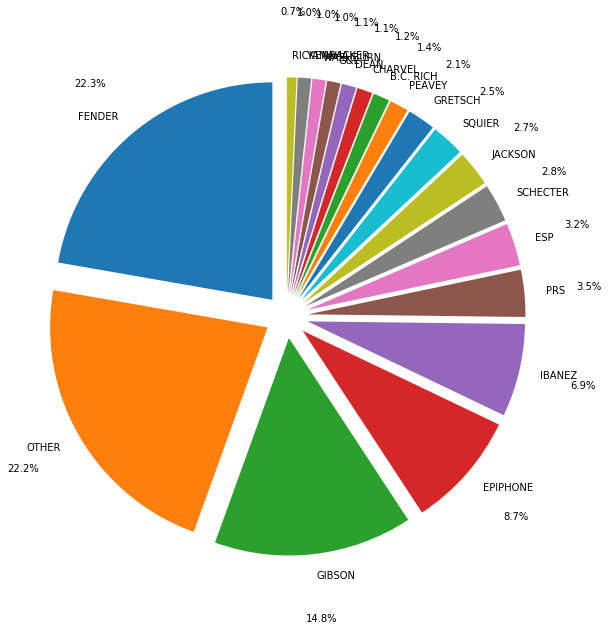

In [55]:
plt.figure(figsize = (10,10))
plt.pie(brand_counts.values, 
        labels = brand_counts.index,
        autopct='%1.1f%%',
        pctdistance = 1.3,
       startangle=90,
        explode = np.full(len(brand_counts), .1))
plt.show()

**Individual Guitar Models**

In [56]:
model_counts = pd.Series([axe.model for axe in axes if axe.brand != None]).value_counts()

There is such a great variety of guitar models. Slivers of the pie smaller than "SQUIER" (rightmost tiny sliver) have been lumped into "OTHER".

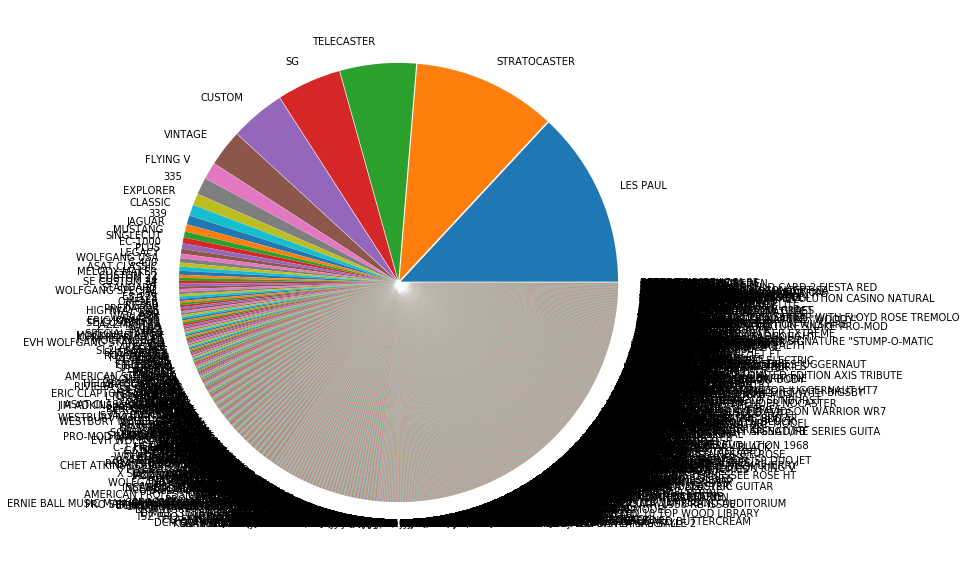

In [57]:
plt.figure(figsize = (10,10))
plt.pie(model_counts.values, labels = model_counts.index,
                            explode = np.full(len(model_counts), .01))
plt.show()

***

__Right or Left Handed:__

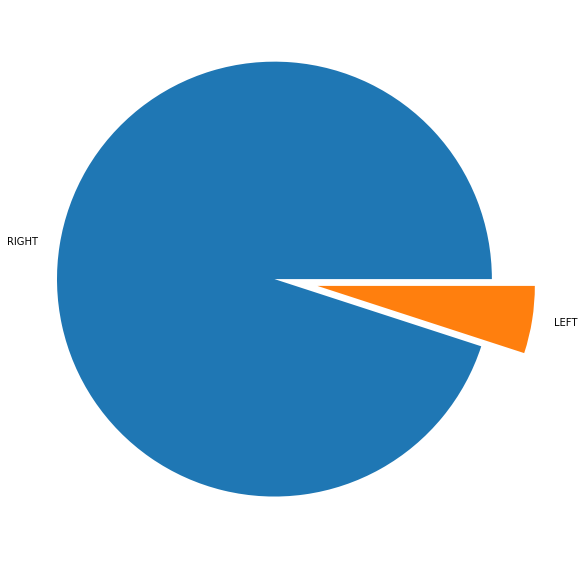

In [58]:
RL = pd.Series([axe.right_left_handed for axe in axes if axe.right_left_handed != None]).value_counts()
plt.figure(figsize = (10,10))
plt.pie(RL.values, labels = RL.index,
                            explode = np.full(len(RL), .1))
plt.show()

***

__Body Types:__

In [59]:
# pd.Series([(axe.title, axe.url) for axe in axes if axe.body_type == 'CLASSICAL']).value_counts()

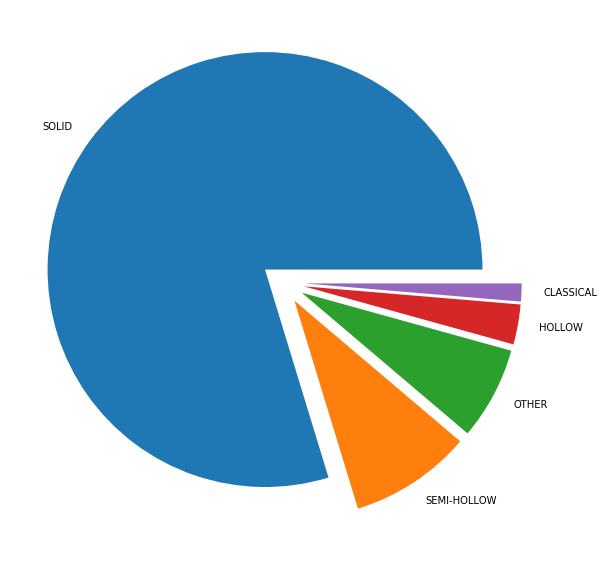

In [60]:
plt.figure(figsize=(10,10))
bodies = pd.Series([axe.body_type for axe in axes if axe.body_type != None]).value_counts()
plt.pie(bodies.values, 
        labels = bodies.index,
       explode = np.full(len(bodies), .1))
plt.show()

In [61]:
print(f'{sum(bodies.values)} aka {round(sum(bodies.values) / len(axes) * 100, 2)}% of listings provide a body type.')

7277 aka 56.03% of listings provide a body type.


****

__Number of Strings:__

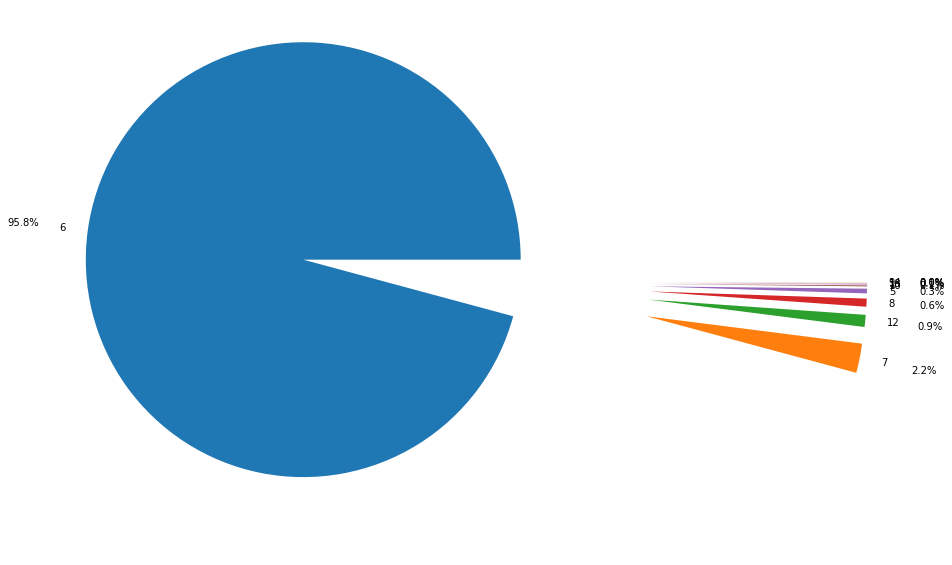

In [62]:
strings = pd.Series([axe.string_config for axe in axes if axe.string_config != None]).value_counts()
plt.figure(figsize = (10,10))
plt.pie(strings.values, 
        labels = strings.index,
        autopct='%1.1f%%',
        pctdistance = 1.3,
       startangle=0,
        explode = np.full(len(strings), .8))
plt.show()

In [63]:
print(f'{sum(strings.values)} aka {round(sum(strings.values) / len(axes) * 100, 2)}% of listings provide a string count.')

8042 aka 61.92% of listings provide a string count.
